In [13]:
import pandas as pd
import seaborn as sns

## Exploratory Data Analysis (EDA)

In [14]:
df = sns.load_dataset("diamonds")
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [15]:
# Check for missing values
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [16]:
print(df["cut"].unique())
print(df["color"].unique())
print(df["clarity"].unique())

['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']
Categories (5, object): ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']
['E', 'I', 'J', 'H', 'F', 'G', 'D']
Categories (7, object): ['D', 'E', 'F', 'G', 'H', 'I', 'J']
['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']
Categories (8, object): ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']


In [17]:
# Show some basic statistics for the numerical features
df[["carat", "depth", "table", "price", "x", "y", "x"]].describe()

,carat,depth,table,price,x,y,x
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,5.731157
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,1.121761
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,4.710000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,5.700000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,6.540000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,10.740000


In [18]:
# Show some basic statistics for the categorical features
df[["cut", "color", "clarity"]].describe()

,cut,color,clarity
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


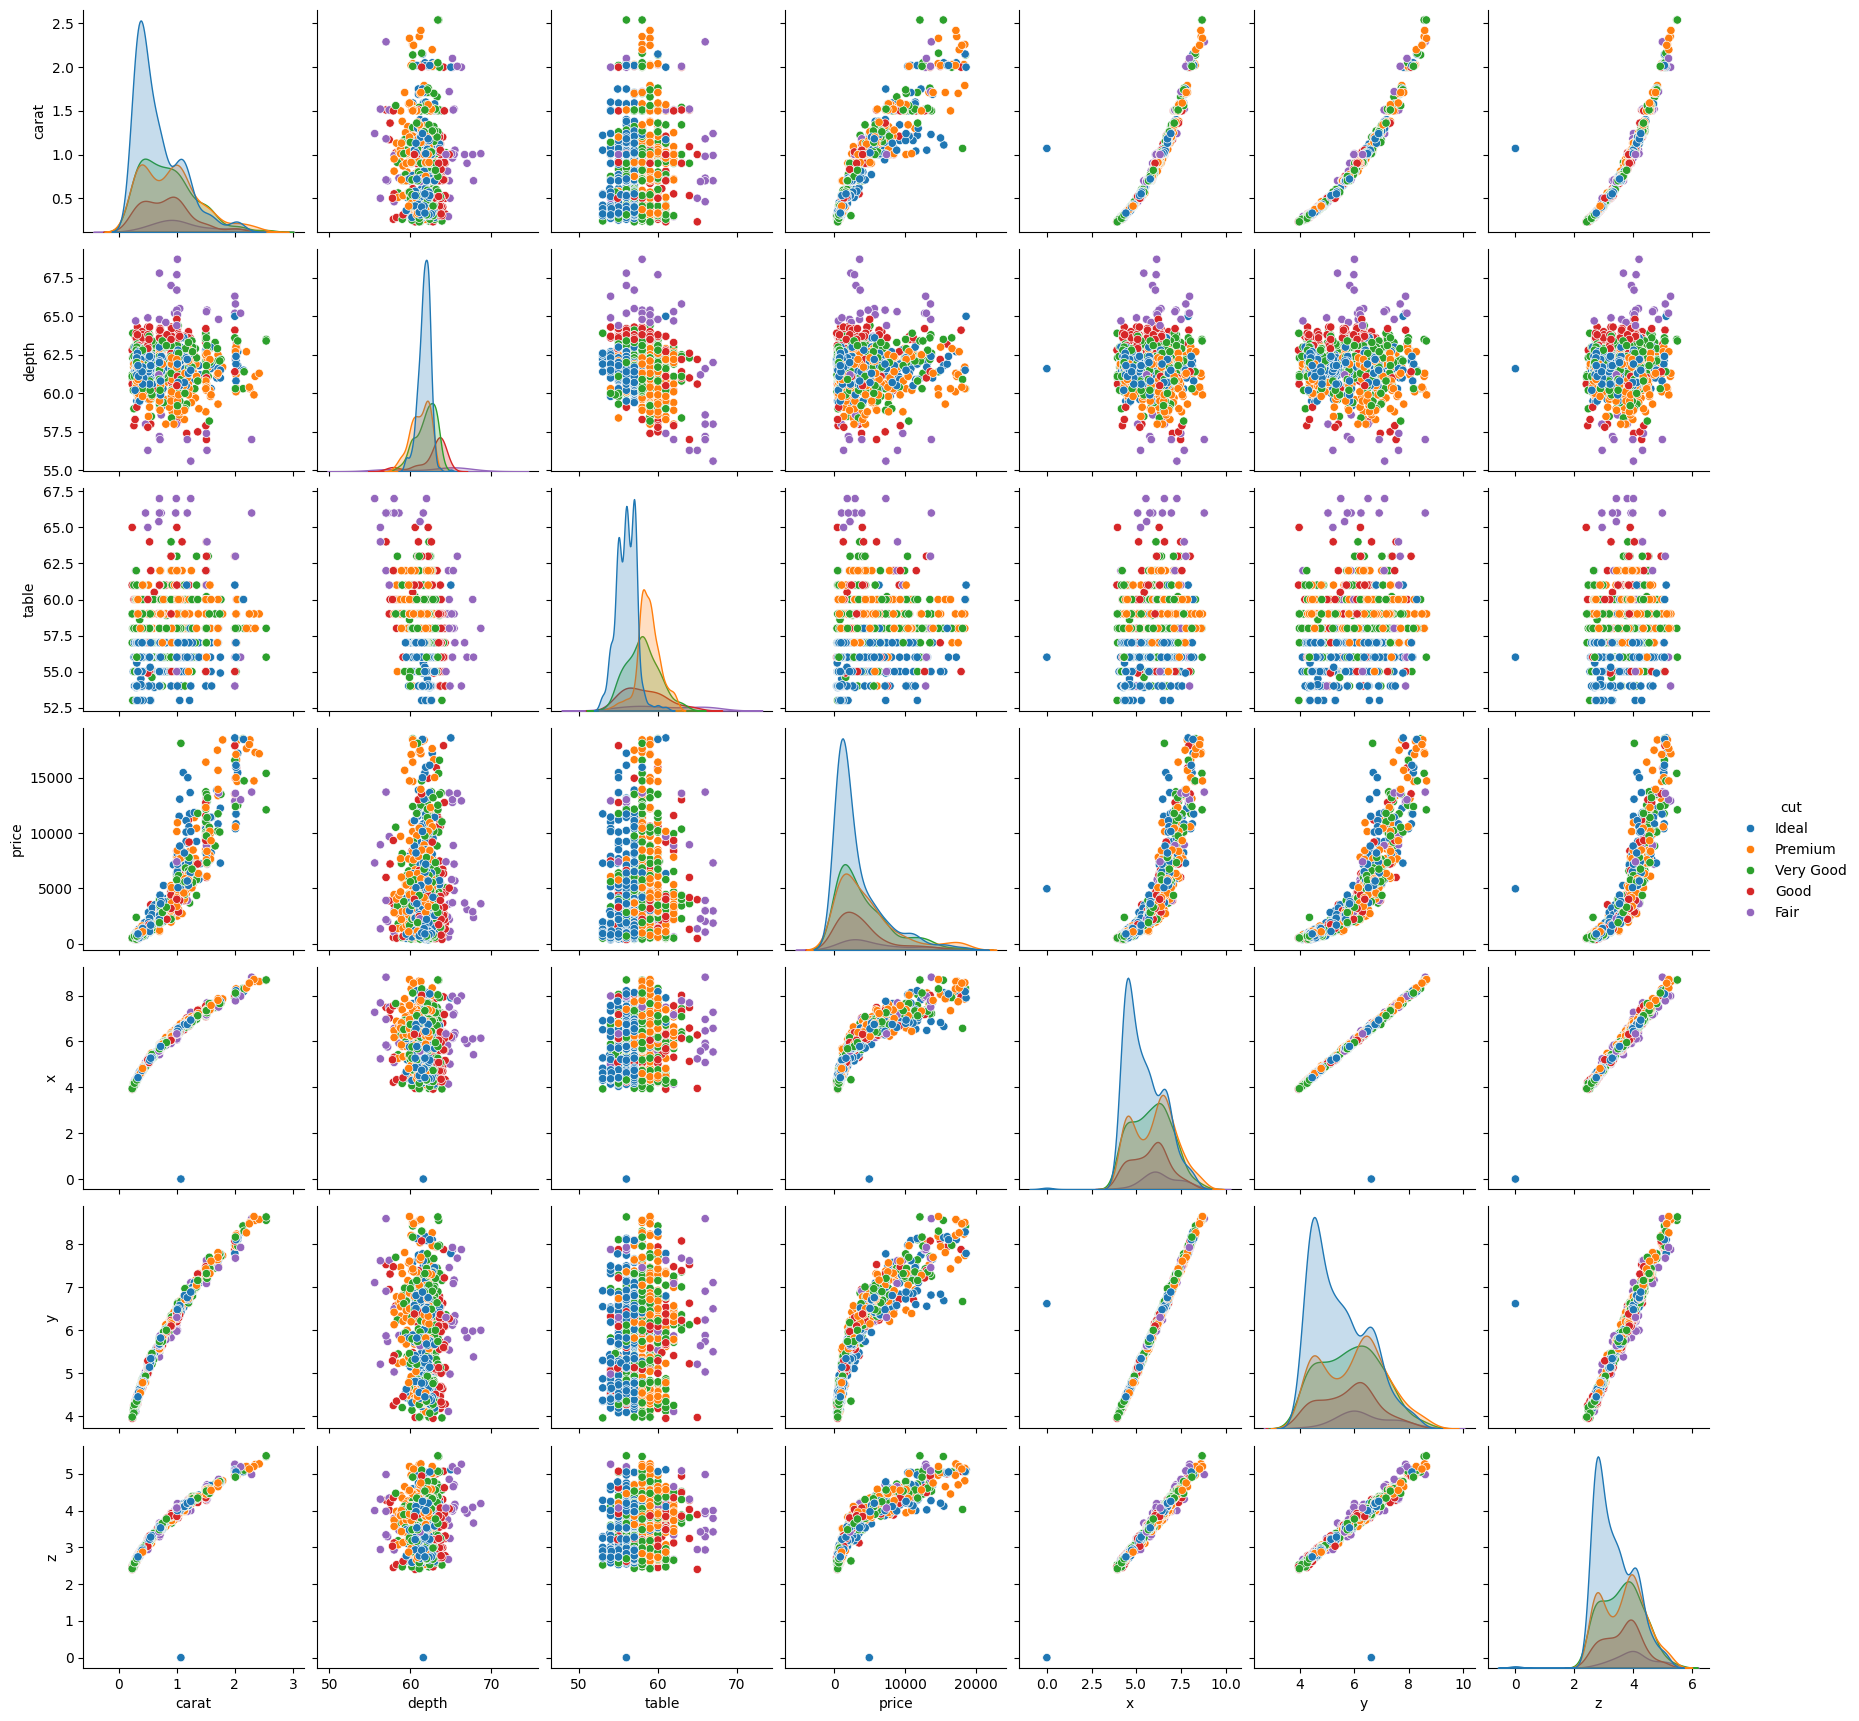

In [19]:
sns.pairplot(df.drop(columns=["color", "clarity"]).sample(frac=1).reset_index(drop=True)[:1000], hue="cut")

## Feature engineering and Training

In [20]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["price"]), df["price"], test_size=0.3, random_state=1)

In [ ]:
import os
from dotenv import load_dotenv
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
import mlflow

load_dotenv()
mlflow.set_tracking_uri(os.environ["MLFLOW_TRACKING_URI"])
# Start MLflow tracking
mlflow.autolog()

# Encodes categorical features (`cut`, `color`, `clarity`) as ordinal integers.
ord_encoder = OrdinalEncoder(categories=[
    ["Fair", "Good", "Very Good", "Premium", "Ideal"],
    ["J", "I", "H", "G", "F", "E", "D"],
    ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"],
])
preprocessor = ColumnTransformer(
    transformers=[("ord", ord_encoder, ["cut", "color", "clarity"])],
    remainder="passthrough", # Leave the other columns unchanged
)

# StackingRegressor is an ensemble model that uses multiple regression models to make predictions.
regressor = StackingRegressor([
    # ElasticNet is a multiple linear regression model with a L1 and L2 regularization term,
    # which means that is combination of LASSO and Ridge regression.
    ("elastic_net", ElasticNet(alpha=0.05, random_state=1)),

    # RandomForestRegressor is an ensemble model that uses multiple decision trees to make predictions.
    # Decision tree is a non-linear regression model that makes of nodes of conditional statement on the features.
    ("random_forest", RandomForestRegressor(n_estimators=10, random_state=1)),
])

pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", regressor),
])

# Show pipeline diagram
from sklearn import set_config
set_config(display='diagram')   
pipe

2025/04/21 09:40:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['J',
                                                                              'I',
                                                                              'H',
                                                                              'G',
                                                                              'F',
                                                                              'E',
                                                                              'D'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('regressor',
                 StackingRegressor(estimators=[('elastic_net',
                                                ElasticNet(alpha=0.05,
                                                           random_state=1)),
                                               ('random_forest',
                                                RandomForestRegressor(n_estimators=10,
                                                                      random_state=1))]))])

In [28]:
set_config(display=None)

In [ ]:
# Fit the pipeline to the training data and evaluate it on the test data.
# During the fit, MLflow will log the model and its parameters, metrics, and artifacts.
with mlflow.start_run(experiment_id=1, run_name='example') as run:
    score = pipe.fit(X_train, y_train).score(X_test, y_test)

print(score)

2025/04/21 09:41:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/k5ki/develop/k5ki/notebooks/.venv/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).
"
2025/04/21 09:41:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run example at: http://iceswarm.e-grant.net:15000/#/experiments/1/runs/d905d0b1ab64403fbe236b458c9bf876
🧪 View experiment at: http://iceswarm.e-grant.net:15000/#/experiments/1
0.9798434690554941


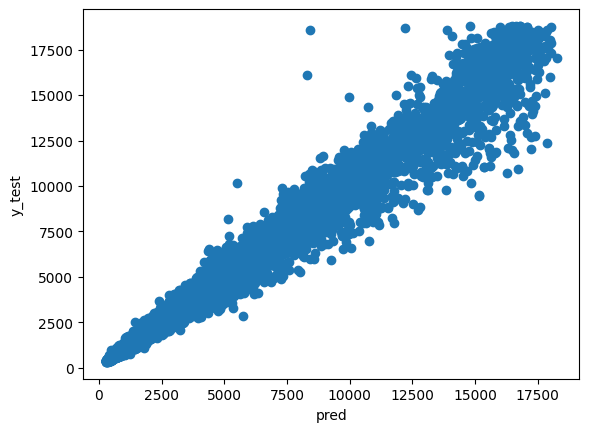

In [30]:
import matplotlib.pyplot as plt

plt.xlabel("pred")
plt.ylabel("y_test")
plt.scatter(pipe.predict(X_test), y_test)

plt.show()

## Deployment

In [25]:
# Register the model in the MLflow Model Registry
run = mlflow.search_runs(order_by=["start_time desc"], max_results=1).iloc[0]
mlflow.register_model(model_uri=f"runs:/{run.run_id}/model", name="diamonds_price_pred")

Successfully registered model 'diamonds_price_pred'.
2025/04/21 09:35:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: diamonds_price_pred, version 1
Created version '1' of model 'diamonds_price_pred'.


<ModelVersion: aliases=[], creation_timestamp=1745228140248, current_stage='None', description='', last_updated_timestamp=1745228140248, name='diamonds_price_pred', run_id='45274e9d325d4f62837ad3f0f32e8c37', run_link='', source='mlflow-artifacts:/0/45274e9d325d4f62837ad3f0f32e8c37/artifacts/model', status='READY', status_message=None, tags={}, user_id='', version='1'>

In [26]:
# Load the model from the MLflow Model Registry
model = mlflow.sklearn.load_model(f"models:/diamonds_price_pred/latest")

idx = 100
pred = model.predict(X_test[idx:idx+1])
ans = y_test[idx:idx+1].values
print(f"pred: {pred}, ans: {ans}")

pred: [6910.07871456], ans: [7533]
